## Customer Segmentation

This notebook aims at analyzing the content of an E-commerce database that lists purchases made by  ∼ 4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase.

#### Contents
1. Data Preparation

2. Exploring the content of variables

- 2.1 Countries
- 2.2 Customers and products
- 2.2.1 Cancelling orders
- 2.2.2 StockCode
- 2.2.3 Basket price

3. Insights on product categories

- 3.1 Product description
- 3.2 Defining product categories
- 3.2.1 Data encoding
- 3.2.2 Clusters of products
- 3.2.3 Characterizing the content of clusters

4. Customer categories

- 4.1 Formating data
- 4.1.1 Grouping products
- 4.1.2 Time spliting of the dataset
- 4.1.3 Grouping orders
- 4.2 Creating customer categories
- 4.2.1 Data enconding
- 4.2.2 Creating categories

5. Classifying customers

- 5.1 Support Vector Machine Classifier (SVC)
- 5.1.1 Confusion matrix
- 5.1.2 Leraning curves
- 5.2 Logistic regression
- 5.3 k-Nearest Neighbors
- 5.4 Decision Tree
- 5.5 Random Forest
- 5.6 AdaBoost
- 5.7 Gradient Boosting Classifier
- 5.8 Let's vote !

6. Testing the predictions

7. Conclusion

#### 1. Data preparation

In [1]:
import sys
print(sys.executable)

C:\Users\User\anaconda3\envs\datascience\python.exe


In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)
plt.rcParams['patch.force_edgecolor'] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth = 1)
%matplotlib inline

In [3]:
# read the datafile
df_initial = pd.read_csv('./datasets/data.csv', encoding = 'ISO-8859-1',
                         dtype = {'CustomerID':str, 'InvoiceID':str})
print('Dataframe dimensions: {}'.format(df_initial.shape))

# datetime conversion
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

# info on column types and number of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index = {0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index = {0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.rename(index = {0:'null values (%)'}))

display(tab_info)
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


While looking at the number of null values in the dataframe, it is interesting to note that  ∼ 25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current analysis, so they are going to be deleted from the dataframe.

In [4]:
# dropping na
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions: {}'.format(df_initial.shape))

# info on column types and number of null values
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index = {0:'column type'})
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index = {0:'null values (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.rename(index = {0:'null values (%)'}))

display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


OK, by removing these entries we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them.

In [5]:
print('Duplicate entries: {}'.format(df_initial.duplicated().sum()))

Duplicate entries: 5225


In [6]:
# dropping duplicates
df_initial.drop_duplicates(inplace = True)

#### 2. Exploring the content of variables

This dataframe contains 8 variables that correspond to:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

#### 2.1 Countries

In [7]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of countries in the dataframe: {}'.format(len(countries)))

Number of countries in the dataframe: 37


In [8]:
# map visualisation
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names', z = countries,
            text = countries.index, colorbar = {'title':'Order nb.'},
            colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
            reversescale = False)

layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection = {'type':'mercator'}))

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

We see that the dataset is largely dominated by orders made from the UK.

#### 2.2 Customers and products
The dataframe contains  ∼ 400,000 entries. What are the number of users and products in these entries?

In [9]:
pd.DataFrame([{'products':len(df_initial['StockCode'].value_counts()),
               'transactions':len(df_initial['InvoiceNo'].value_counts()),
               'customers':len(df_initial['CustomerID'].value_counts())}],
             columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


It can be seen that the data concern 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of  ∼ 22'000.

Now I will determine the number of products purchased in every transaction.

In [10]:
temp = df_initial.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The first lines of this list shows several things worthy of interest:

- the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order


##### 2.2.1 Cancelling orders
First of all, I count the number of transactions corresponding to canceled orders.

In [11]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: int('C' in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]

print('Number of orders canceled: {}/{} ({:.2f}%)'.format(n1, n2, n1 / n2 * 100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654/22190 (16.47%)


We note that the number of cancellations is quite large ( ∼ 16% of the total number of transactions). Now, let's look at the first lines of the dataframe.

In [12]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the Quantity and InvoiceDate variables. I decide to check if this is true for all the entries. To do this, I decide to locate the entries that indicate a negative quantity and check if there is systematically an order indicating the same quantity (but positive), with the same description (CustomerID, Description and UnitPrice).

In [13]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID', 'Quantity', 'StockCode',
                                                   'Description', 'UnitPrice']]

for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == - col[1]) & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(df_check.loc[index])
        print(15 * '-' + '>' + ' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a 'Discount' entry. I check again the hypothesis but this time discarding the 'Discount' entries.

In [14]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice']]

for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == - col[1]) & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(index, df_check.loc[index])
        print(15 * '-' + '>' + ' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new variable in the dataframe that indicate if part of the command has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database). Below, I make a census of the cancel orders and check for the existence of counterparts.

In [15]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtful_entry = []

for index, col in df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode'] == col['StockCode']) &
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) &
                         (df_initial['Quantity'] > 0)].copy()
    
    # cancelation without counterpart
    if (df_test.shape[0] == 0):
        doubtful_entry.append(index)
    
    # cancelation with counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = - col['Quantity']
        entry_to_remove.append(index)
        
    # various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis = 0, ascending = False, inplace = True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < - col['Quantity']:continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = - col['Quantity']
            entry_to_remove.append(index)
            break

In the above loop, I checked the two cases:

1. a cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order is respectively kept in the doubtfull_entry and entry_to_remove lists whose sizes are:

In [16]:
print('entry to remove: {}'.format(len(entry_to_remove)))
print('doubtful entry: {}'.format(len(doubtful_entry)))

entry to remove: 7521
doubtful entry: 1226


Among these entries, the lines listed in the doubtfull_entry list correspond to the entries indicating a cancellation but for which there is no command beforehand.

If we have a look at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, we observe:

In [17]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


We see that the quantity canceled is greater than the sum of the previous purchases.

##### 2.2.2 StockCode

Above, it has been seen that some values of the StockCode variable indicate a particular transaction (i.e. D for Discount). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [18]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex = True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [19]:
for code in list_special_codes:
    print('{:<15} -> {:<30}'.format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                
CRUK            -> CRUK Commission               


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.

##### 2.2.3 Basket Price

I create a new variable that indicates the total price of every purchase:

In [20]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,0,-77183.6
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland,0,17.0
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland,0,13.2
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,0,15.0


Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order prize:

In [21]:
# sum of purchases grouped by customer and order
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# date of order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
2,12347,537626,711.79,2010-12-07 14:57:00.000001024
3,12347,542237,475.39,2011-01-26 14:29:59.999999744
4,12347,549222,636.25,2011-04-07 10:42:59.999999232
5,12347,556201,382.52,2011-06-09 13:01:00.000000256
6,12347,562032,584.91,2011-08-02 08:48:00.000000000
7,12347,573511,1294.32,2011-10-31 12:25:00.000001280


In order to create a global view of the amount range of orders in this dataset, I determine how the purchases are divided with respect to the amount range of total prices:

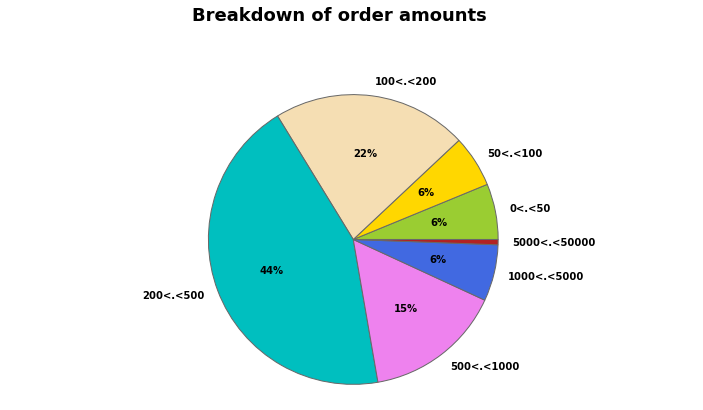

In [22]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []

for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i - 1])]['Basket Price'].count()
    count_price.append(val)
    
# representation of the number of purchases
plt.rc('font', weight = 'bold')
fig, ax = plt.subplots(figsize = (11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ['{}<.<{}'.format(price_range[i - 1], s) for i, s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = lambda x: '{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
fig.text(0.5, 1.01, 'Breakdown of order amounts', ha = 'center', fontsize = 18)
plt.show()

It can be seen that the vast majority of orders consists of relatively large purchases given that  ∼ 65% of purchases are in amount that excesses £200.

#### 3. Insights on product categories

In the dataframe, products are uniquely identified through the StockCode variable. A short description of the products is given in the Description variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

##### 3.1 Products description

As a first step, I extract the information from the Description variable. To do this, I use the following function:

In [23]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, column = 'Description'):
    stemmer = nltk.stem.SnowballStemmer('english')
    keywords_roots = dict() # collect the words/root
    keywords_select = dict() # association: root <--> keyword
    category_keys = []
    count_keywords = dict()
    icount = 0
    for s in dataframe[column]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        for t in nouns:
            t = t.lower(); root = stemmer.stem(t)
            if root in keywords_roots:
                keywords_roots[root].add(t)
                count_keywords[root] += 1
            else:
                keywords_roots[root] = {t}
                count_keywords[root] = 1
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    key = k; min_length = len(k)
            category_keys.append(key)
            keywords_select[s] = key
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    print("nb of keywords in variable '{}' : {}".format(column, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

- extract the names appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [24]:
df_products = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [25]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

nb of keywords in variable 'Description' : 1484


The execution of this function returns three variables:

- keywords: the list of extracted keywords
- keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- count_keywords: dictionary listing the number of times every word is used

At this point, I convert the count_keywords dictionary into a list, to sort the keywords according to their occurences:

In [26]:
list_products = []

for k, v in count_keywords.items():
    list_products.append([keywords_select[k], v])
list_products.sort(key = lambda x: x[1], reverse = True)

Using it, I create a representation of the most common keywords:

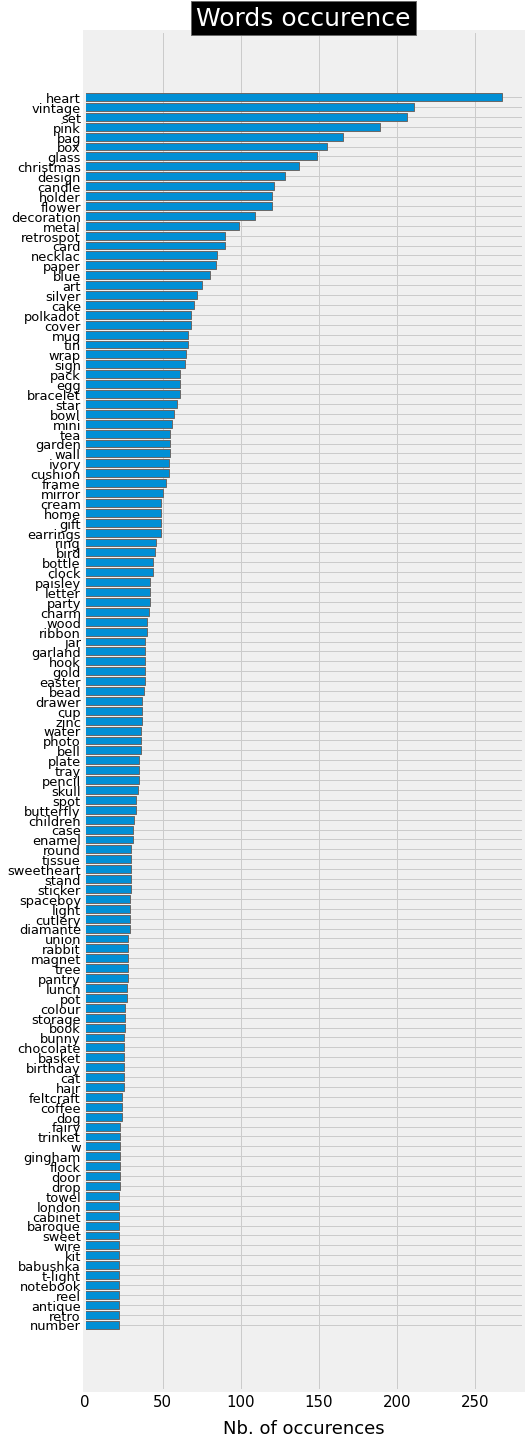

In [27]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)

plt.rc('font', weight = 'normal')
fig, ax = plt.subplots(figsize = (7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
plt.title("Words occurence",bbox = {'facecolor':'k', 'pad':5}, color = 'w',fontsize = 25)
plt.show()

##### 3.2 Defining product categories

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examining the content of the list, I note that some names are useless. Others do not carry information, like colors. Therefore, I discard these words from the analysis that follows and moreover, I decide to consider only the words that appear more than 13 times.

In [28]:
list_products = []

for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
    
list_products.sort(key = lambda x: x[1], reverse = True)
print('preserved words: {}'.format(len(list_products)))    

preserved words: 193


##### 3.2.1 Data encoding
Now, I will use these keywords to create groups of products. Firstly, I define the X matrix:

In [29]:
liste_products = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] =list(map(lambda x: int(key.upper() in x), liste_products))

The  X  matrix indicates the words contained in the description of the products using the one-hot-encoding principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [30]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []

for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i + 1])
    label_col.append(col)
    X.loc[:, col] = 0
    
for i, prod in enumerate(liste_products):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j += 1
        if j == len(threshold): break
    X.loc[i, label_col[j - 1]] = 1

... and to choose the appropriate ranges, I check the number of products in the different groups:

In [31]:
print("{:<8} {:<20} \n".format('gamme', 'nb.products') + 20* '-')

for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i + 1])
    print("{:<10} {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb.products          
--------------------
0<.<1      965                 
1<.<2      1013                
2<.<3      674                 
3<.<5      611                 
5<.<10     476                 
.>10       157                 


##### 3.2.2 Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the Hamming's metric. Note that k-means method of sklearn uses Euclidean distance, but it is not the best possible alternative to use in case of categorical variables. However, in order to use the Hemming's metric, we need to use the kmodes package which is not available on the current platform. Hence, I use k-means method even if this is not the best choice in terms of convenience.

In order to define (approximately) the number of clusters taht best represents the data, I will use the silhouette score:

In [32]:
matrix = X.to_numpy()

for n_clusters in range(3, 10):
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(n_clusters, silhouette_avg))

For n_clusters = 3 the average silhouette_score is: 0.10150779068464941
For n_clusters = 4 the average silhouette_score is: 0.12673477668888355
For n_clusters = 5 the average silhouette_score is: 0.14580405128643806
For n_clusters = 6 the average silhouette_score is: 0.14501021114420656
For n_clusters = 7 the average silhouette_score is: 0.1461644275396298
For n_clusters = 8 the average silhouette_score is: 0.14755149809105958
For n_clusters = 9 the average silhouette_score is: 0.14951795051680775


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of 0.1 +- 0.05 will be obtained for all clusters with n_clusters > 3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate until we obtain the best possible silhouette score, which is, in the present case, about 0.15:

In [33]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print('For n_clusters = {} the average silhouette_score is: {}'.format(n_clusters, silhouette_avg))

For n_clusters = 5 the average silhouette_score is: 0.14580405128643806


##### 3.2.3 Characterizing the content of clusters
I check the number of elements in every class:

In [34]:
pd.Series(clusters).value_counts()

3    1164
1     965
0     674
4     611
2     482
dtype: int64

##### a) silhouette intra-cluster score
In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the sklearn documentation:

In [35]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth = 1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    #___________________________
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor = color, edgecolor = color, alpha = 0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle = 'round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10 

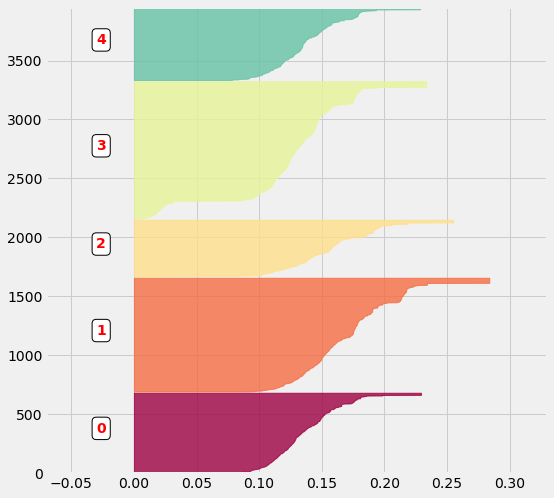

In [36]:
# define individual silhouette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)

# and here comes the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

##### b) principal component analysis
In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [37]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

... and then check for the amount of variance determined by each component:

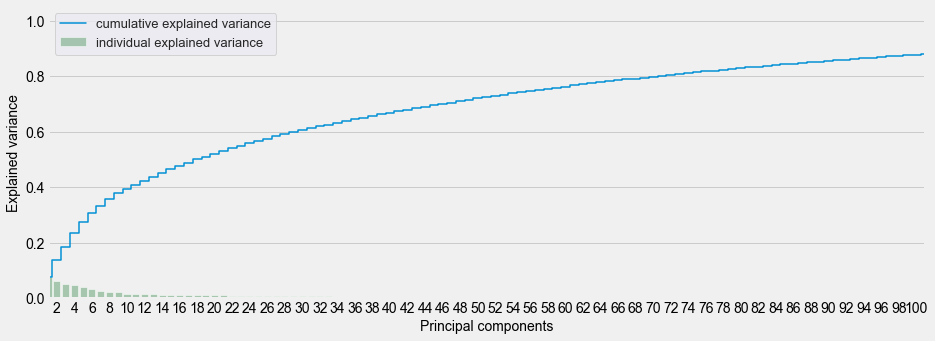

In [38]:
fig, ax = plt.subplots(figsize = (14, 5))
sns.set(font_scale = 1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(),
         where = 'mid', label = 'cumulative explained variance')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_,
            alpha = 0.5, color = 'g', label = 'individual explained variance')
plt.xlim(0, 100)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])
plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

We can see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since the decomposition is only performed to visualize the data:

In [39]:
pca = PCA(n_components = 50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

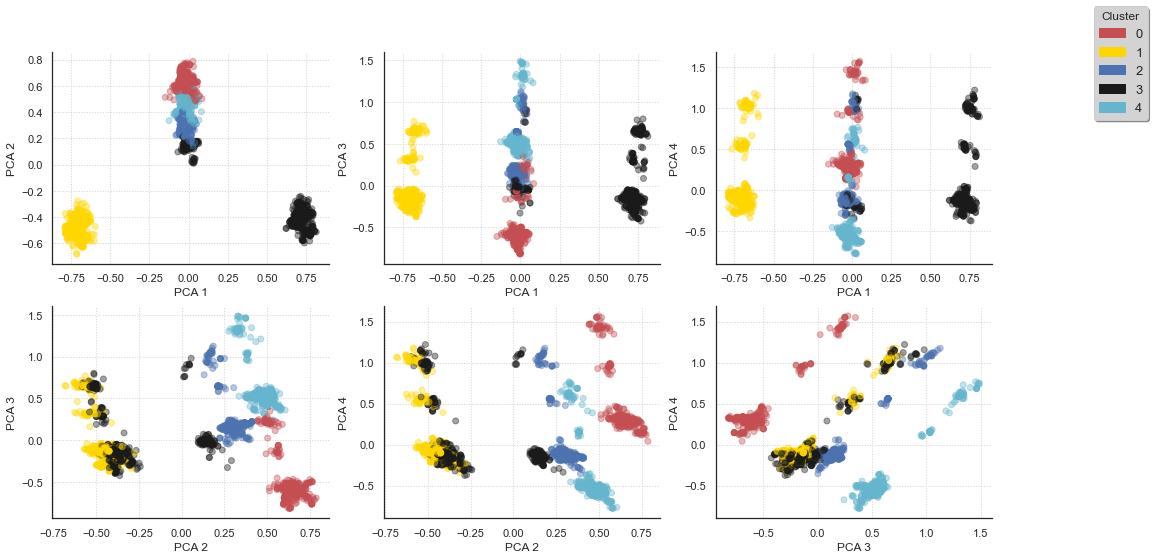

In [40]:
import matplotlib.patches as mpatches

sns.set_style('white')
sns.set_context('notebook', font_scale = 1, rc = {'lines.linewidth':2.5})

label_color_map = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [label_color_map[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15, 8))
increment = 0
for ix in range(4):
    for iy in range(ix + 1, 4):
        increment += 1
        ax = fig.add_subplot(2, 3, increment)
        ax.scatter(mat[ix], mat[iy], c = label_color, alpha = 0.4)
        plt.ylabel('PCA {}'.format(iy + 1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix + 1), fontsize = 12)
        ax.yaxis.grid(color = 'lightgray', linestyle = ':')
        ax.xaxis.grid(color = 'lightgray', linestyle = ':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
# legend stuff: abreviation --> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = label_color_map[i], label = i))
    
plt.legend(handles = comp_handler, bbox_to_anchor = (1.1, 0.97),
           title = 'Cluster', facecolor = 'lightgray',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)
plt.show()

#### 4. Customer categories

##### 4.1 Formatting data
In the previous section, the different produts were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists of introducing this information into the dataframe. To do this, I create the categorical variable categ_product where I indicate the cluuster of each product:

In [41]:
corresp = dict()
for key, val in zip(liste_products, clusters):
    corresp[key] = val

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

##### 4.1.1 Grouping products
In a second step, I decide to create the categ_N variables (with N e [0:4]) that contains the amount spent in each product category:

In [42]:
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x: x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
    
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1',
            'categ_2', 'categ_3', 'categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.0,0.0,0.0,0.00
1,536365,WHITE METAL LANTERN,4,0.0,0.0,0.0,0.0,20.34
2,536365,CREAM CUPID HEARTS COAT HANGER,4,0.0,0.0,0.0,0.0,22.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.0,0.0,0.0,0.0,20.34
4,536365,RED WOOLLY HOTTIE WHITE HEART.,4,0.0,0.0,0.0,0.0,20.34


Up to now, the information releated to a single order was split over several lines of the dataframe (one line per product). I decided to collect the information related to a particular order and put it in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [43]:
# sum of purchases/user & order
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

# percentage of order price/product category
for i in range(5):
    col = 'categ_{}'.format(i)
    temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)[col].sum()
    basket_price.loc[:, col] = temp
    
# date of order
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# selection of significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
2,12347,537626,711.79,83.40,23.40,124.44,187.20,293.35,2010-12-07 14:57:00.000001024
3,12347,542237,475.39,53.10,84.34,0.00,168.75,169.20,2011-01-26 14:29:59.999999744
4,12347,549222,636.25,71.10,81.00,0.00,369.15,115.00,2011-04-07 10:42:59.999999232
5,12347,556201,382.52,78.06,41.40,19.90,74.40,168.76,2011-06-09 13:01:00.000000256
6,12347,562032,584.91,119.70,61.30,97.80,147.95,158.16,2011-08-02 08:48:00.000000000


##### 4.1.2 Data separation over time
The dataframe basket_price contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizng and anticipating the habits of the customers visiting the site. In order to be able to test the model in a realistic way, I split the dataset by retaining the first 10 months to develop the model and the following 2 months to test the model:

In [44]:
print(basket_price['InvoiceDate'].min(), '-->', basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 --> 2011-12-09 12:50:00


In [45]:
basket_price['InvoiceDate'] = pd.to_datetime(basket_price['InvoiceDate'])
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

TypeError: Invalid comparison between dtype=datetime64[ns] and date

##### 4.1.3 Consumer order combinations
In a second step, I group together the differernt entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all visits:

In [46]:
# number of visits and stats on the amount of the cart / users
transactions_per_user = basket_price.groupby(by = ['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:, col] = basket_price.groupby(by =['CustomerID'])[col].sum()
/\
                                        transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by = ['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,7,224.82,1294.32,615.714286,4310.00,896.70,484.32,327.74,1328.05,1273.19
1,12348,4,227.44,892.80,449.310000,1797.24,0.00,683.24,0.00,1114.00,0.00
2,12349,1,1757.55,1757.55,1757.550000,1757.55,215.22,79.32,358.35,916.36,188.30
3,12350,1,334.40,334.40,334.400000,334.40,93.30,39.10,0.00,202.00,0.00
4,12352,7,144.35,840.30,340.815714,2385.71,97.13,31.00,350.50,1558.73,348.35


Finally, I define two additional variables that give the number of days elapsed since the first purchase (FirstPurchase) and the number of days since the last purchase (LastPurchase):

In [47]:
last_date = basket_price['InvoiceDate'].max().date()
first_registration = pd.DataFrame(basket_price.groupby(by = ['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by = ['CustomerID'])['InvoiceDate'].max())

test = first_registration.applymap(lambda x: (last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x: (last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,896.70,484.32,327.74,1328.05,1273.19,2,367
1,12348,4,227.44,892.80,449.310000,1797.24,0.00,683.24,0.00,1114.00,0.00,75,358
2,12349,1,1757.55,1757.55,1757.550000,1757.55,215.22,79.32,358.35,916.36,188.30,18,18
3,12350,1,334.40,334.40,334.400000,334.40,93.30,39.10,0.00,202.00,0.00,310,310
4,12352,7,144.35,840.30,340.815714,2385.71,97.13,31.00,350.50,1558.73,348.35,36,296


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customers represents 1/3 of the customers listed:

In [48]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print('number of customers with only one order: {:<2}/{:<5}  ({:<2.2f}%)'.format(n1, n2, n1/n2*100))

number of customers with only one order: 1489/4327   (34.41%)


##### 4.2 Creation of customer categories

##### 4.2.1 Data encoding
The dataframe transactions_per_user contains a summary of all the orders taht were made. Each entry in this dataframe corresponds to a particular customer. I use this information to characterize the diferent types of customers and only keep a subset of variables:

In [49]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']

selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I create a matrix where these data are standardized:

In [50]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' +90*'-' + '\n', scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.25190663 241.38253571 578.87676959 372.25705475 466.3228819
 227.52536469 300.05848394 601.01897412 345.5012942 ]


In the following cell, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the scaled_matrix matrix. In this case, I will use this base in order to create a representation of diffrent clusters and thus verify the quality of the separation into diffrent groups. I therefore perform a PCA beforehand:

In [51]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

... and I represent the amount of variance explained by each of the components:

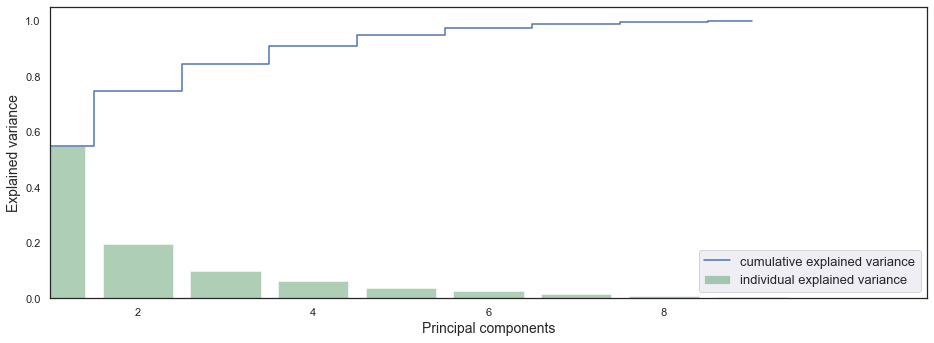

In [52]:
fig, ax = plt.subplots(figsize = (14, 5))
sns.set(font_scale = 1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'cumulative explained variance')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g', label = 'individual explained variance')
plt.xlim(0, 10)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])
plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc = 'best', fontsize = 13)
plt.show()

4.2.2 Creation of customer categories

At this point, I define clusters of customers from the standardized matrix that was defined earlier and using k-means algorithm from scikit-learn library. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 11 clusters:

In [53]:
n_clusters = 11
kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 100)
kmeans.fit(scaled_matrix)
clusters_customers = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_customers)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.377


First, I look at the number of customers in each cluster:

In [54]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['number of customers']).T

,10,5,0,2,6,8,7,9,1,3,4
number of customers,2316,1203,564,146,63,14,12,5,2,1,1


##### a) Report via the PCA
There is a certain disparity in the sizes of different groups that have been created. I will now try to understand the content of these clusters in order to validate (or not) this particular separation. First, I use the result of the PCA:

In [55]:
pca = PCA(n_components = 6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_customers)

... in order to create a representation of the various clusters:

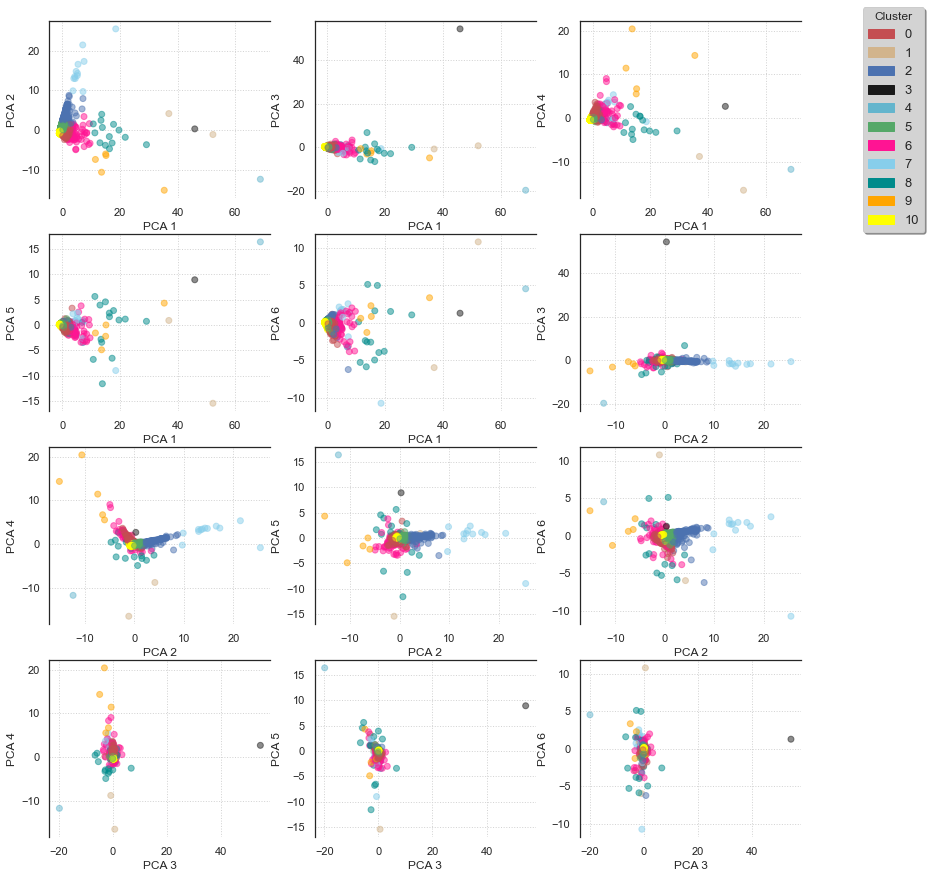

In [56]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale = 1, rc = {"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,14))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4, 3, increment)
        ax.scatter(mat[ix], mat[iy], c = label_color, alpha = 0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color = 'lightgray', linestyle =':')
        ax.xaxis.grid(color = 'lightgray', linestyle =':')
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

From this representation, it can be seen, for instance, that the first principal component allows to separate the tiniest clusters from from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

##### b) Intra-cluster silhouette score
As with product categories, another way to look at the quality of the separation is to look at silhouette scores within different clusters:

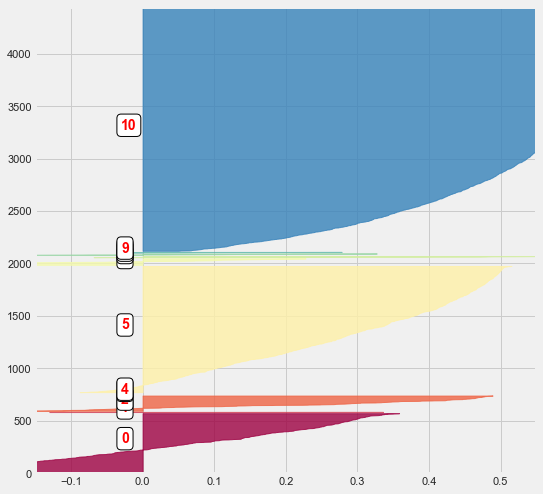

In [57]:
# define individual silhouette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_customers)

# and make the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_customers)

##### c) Customers morphotype
At this stage, I have verified that the different clusters are indeed disjoint (at least in a global view). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the selected_customers dataframe a variable that defines the cluster to which each customer belongs:

In [58]:
selected_customers.loc[:, 'cluster'] = clusters_customers

Then, I average the contents of this dataframe by selecting the different groups of customers. This gives access to, for instance, the average basket price, the number of visits or the total sums spent by the customers of the different clusters. I also determine the number of customers in each group (variable size):

In [59]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
    
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('Number of customers: {}'.format(merged_df['size'].sum()))

merged_df = merged_df.sort_values('sum')

Number of customers: 4327


Finally, I reorganize the content of the dataframe by ordering by the different clusters: first, in relation to the amount spent in each product category and then, with relation to the total amount spent:

In [60]:
list_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 45].index.values[0])
    
list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]

merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,10.0,2.658895,127.723204,268.852915,193.934955,552.411642,120.470350,75.398606,83.582487,177.668291,95.354491,2316
1,10.0,2.658895,127.723204,268.852915,193.934955,552.411642,120.470350,75.398606,83.582487,177.668291,95.354491,2316
2,10.0,2.658895,127.723204,268.852915,193.934955,552.411642,120.470350,75.398606,83.582487,177.668291,95.354491,2316
3,10.0,2.658895,127.723204,268.852915,193.934955,552.411642,120.470350,75.398606,83.582487,177.668291,95.354491,2316
4,10.0,2.658895,127.723204,268.852915,193.934955,552.411642,120.470350,75.398606,83.582487,177.668291,95.354491,2316
5,5.0,2.102244,389.477258,564.014057,469.122783,1019.995462,230.349451,132.372528,145.096825,338.834613,173.429244,1203
6,2.0,1.938356,1141.534795,1640.582336,1373.287405,2748.530692,623.466644,284.761993,385.318219,906.253082,548.750959,146
7,0.0,11.088652,104.436560,864.528954,417.491921,4134.250106,971.289947,526.928014,608.043741,1303.358989,725.055957,564
8,7.0,1.500000,4075.741667,6245.503333,5073.737778,7931.028333,2409.963333,814.708333,1140.975000,2447.824167,1117.557500,12
9,6.0,28.269841,73.929683,2517.482857,791.393743,16705.887937,4518.685556,1668.854603,2421.151111,4836.239048,3261.370317,63


##### d) Customers morphology
Finally, I create representation of the diffrent morphotypes. To do so, i define a class to create 'Radar Charts':

In [61]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):
        angles = np.arange(0, 360, 360./len(variables))
        ix, iy = location[:] ; size_x, size_y = sizes[:]
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, label = 'axes{}'.format(i)) for i in range(len(variables))]
        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid('off')
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num = n_ordinate_levels)
            grid_label = ['']+['{:.0f}'.format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
            
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        
    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

This allows to have a global overview of the content of each cluster:

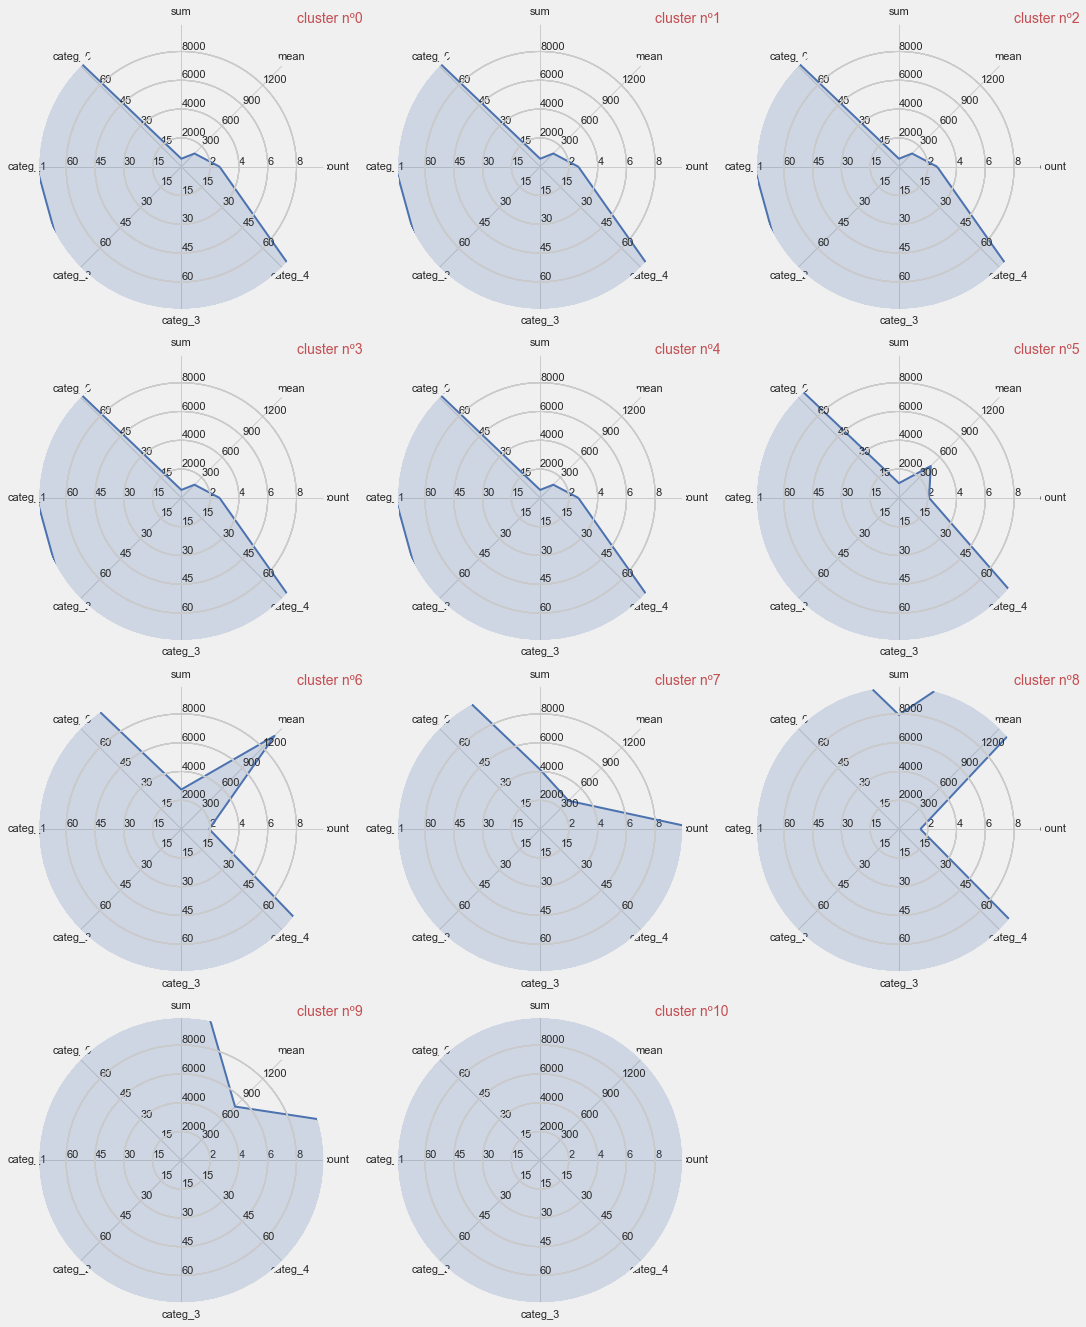

In [62]:
fig = plt.figure(figsize = (13, 12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups // i_cols
size_x, size_y = (1 / i_cols), (1 / i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind // 3
    pos_x = ix * (size_x + 0.05) ; pos_y = iy * (size_y + 0.05)
    location = [pos_x, pos_y] ; sizes = [size_x, size_y]
    
    data = np.array(merged_df.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth = 2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1

It can be seen, for instance, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from from basket averages (mean), the total sum spent by the clients (sum) or the total number of vistis made (count).

#### 5. Classification of customers

In this part, the objective will be to adjust a classifier to that will classify consumer into diffrent customer categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented from sciki-learn library. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers:

In [63]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
y = selected_customers['cluster']

Subsequently, I split the dataset into train set and test set:

In [64]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

##### 5.1 Support vector machine classifier (SVC)
The first classifier i use is the SVC. In order to use it, I create an instance of the SVC() class and call GridSearchCV(). When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

In [65]:
svc = SVC()
clf = SVC(kernel = 'linear')
clf = GridSearchCV(estimator = svc, param_grid = {'C':np.logspace(-2, 2, 10)}, cv = 5)

Once this instance is created, I adjust the classifier to training data:

In [66]:
clf.fit(X_train, y_train)

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])})

... then, I can test the quality of the prediction with respect to the test data:

In [67]:
score = clf.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 91.69%


##### 5.1.1 Confusion matrix
The accuracy of the results seem to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains about 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the instances of the different classes. This is the subject of the confusion matrix and to represent them, I define the following function:

In [68]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normaliztion')
        
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh =cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [69]:
preds = clf.predict(X_test)

... from which I create the following representation:

Confusion matrix, without normaliztion


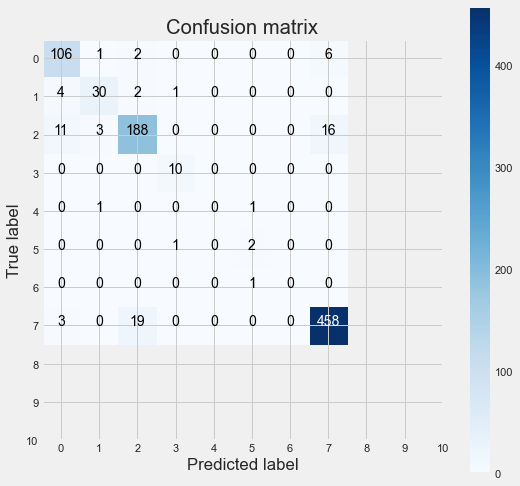

In [70]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision = 2)
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Confusion matrix')

##### 5.1.2 Learning curve
A typical way to test the quality of a fit is to draw a learning curve. In particular, these types of curves allow to detect possible drawbacks in the model, linked to, for instance, to over or under fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I define the following function:

In [71]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = -1, train_sizes = np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color = 'r', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')
    plt.legend(loc = 'best')
    return plt

... from which I represent the learning curve of the SVC:

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



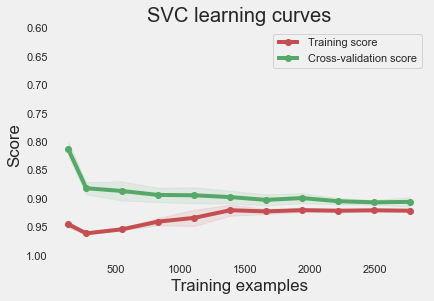

In [72]:
g = plot_learning_curve(clf.best_estimator_, 'SVC learning curves', X_train, y_train, ylim = [1.01, 0.6], cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence, the model does not suffer from underfitting either.

##### 5.2 Logistic regression

I now take into consideration the logistic regression classifier. As before, I create an instance of LogisticRegresion() class, adjust the model with respect to training data and see how the predictions compare to the real values:

In [127]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(preprocessing.StandardScaler().fit_transform(X), y, test_size=0.2)

In [132]:
log_regression = linear_model.LogisticRegression(max_iter = 5000, solver = 'lbfgs')
log_regression_cv = GridSearchCV(estimator = log_regression, param_grid = [{'C':np.logspace(-2, 2, 20)}], cv = 5)

In [137]:
log_regression = log_regression_cv.fit(X_train, y_train)

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [148]:
score = log_regression_cv.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 87.99%


In [149]:
preds = log_regression_cv.predict(X_test)

Confusion matrix, without normaliztion


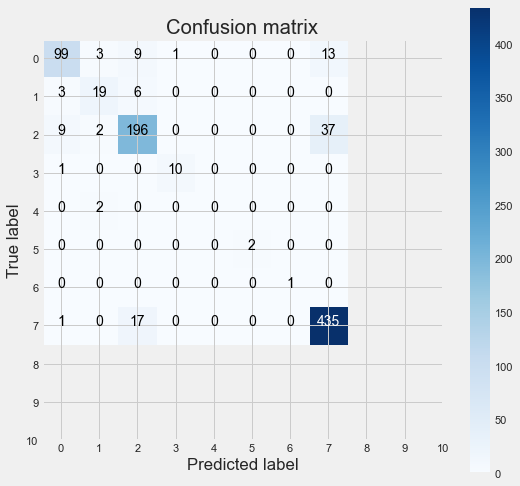

In [150]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision = 2)
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Confusion matrix')

##### Then, I plot the learning curve to have a feeling of the quality of the model:

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



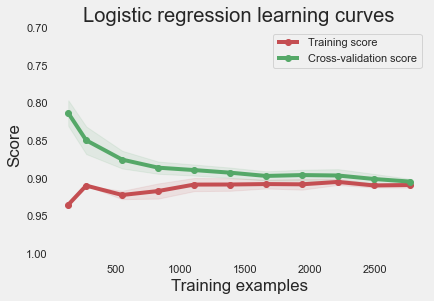

In [151]:
g = plot_learning_curve(log_regression_cv.best_estimator_, 'Logistic regression learning curves', X_train, y_train, ylim = [1.01, 0.7],
                        cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

##### 5.3 k-Nearest neighbors

In [143]:
knn = neighbors.KNeighborsClassifier()
knn_cv = GridSearchCV(estimator = knn, param_grid = [{'n_neighbors':np.arange(1, 50, 1)}], cv = 5)

In [144]:
knn_cv = knn_cv.fit(X_train, y_train)

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [145]:
score = knn_cv.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 89.38%


In [146]:
preds = knn_cv.predict(X_test)

Confusion matrix, without normaliztion


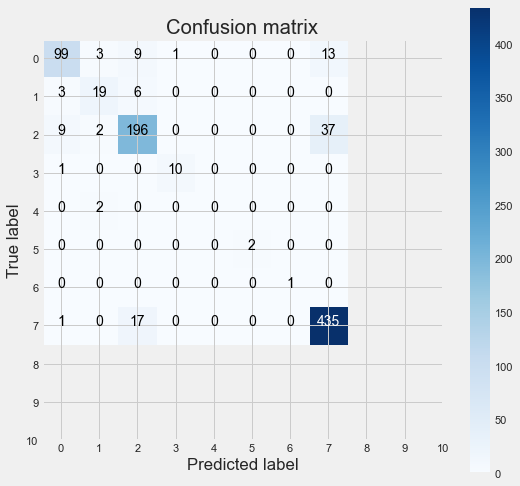

In [152]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision = 2)
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Confusion matrix')

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



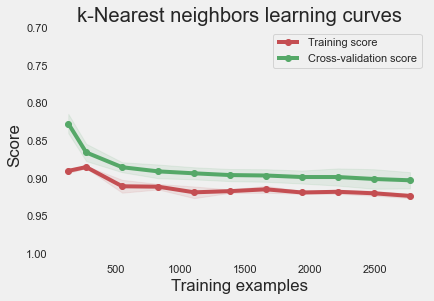

In [155]:
g = plot_learning_curve(knn_cv.best_estimator_, 'k-Nearest neighbors learning curves', X_train, y_train, ylim = [1.01, 0.7],
                        cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

##### 5.4 Decision tree

In [167]:
from sklearn.tree import DecisionTreeClassifier

In [169]:
decision_tree = DecisionTreeClassifier()
decision_tree_cv = GridSearchCV(estimator = decision_tree, param_grid = [{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2']}], cv = 5)

In [170]:
decision_tree_cv = decision_tree_cv.fit(X_train, y_train)

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [171]:
score = decision_tree_cv.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 83.37%


In [172]:
preds = decision_tree_cv.predict(X_test)

Confusion matrix, without normaliztion


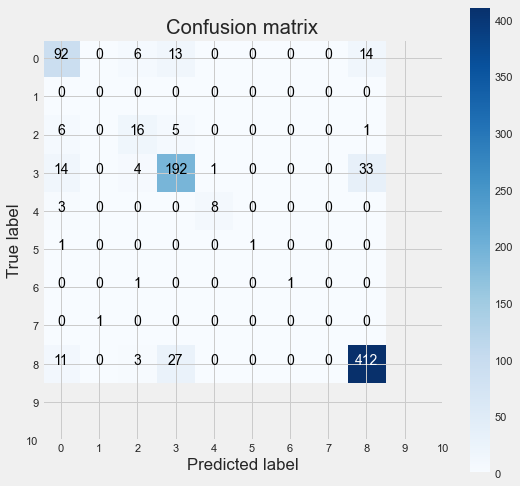

In [173]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision = 2)
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Confusion matrix')

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



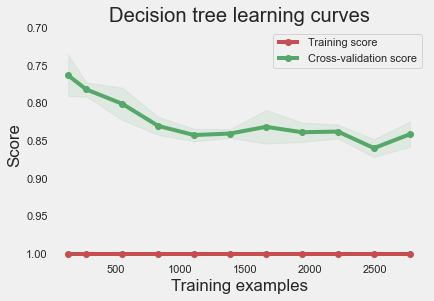

In [174]:
g = plot_learning_curve(decision_tree_cv.best_estimator_, 'Decision tree learning curves', X_train, y_train, ylim = [1.01, 0.7],
                        cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

##### 5.5 Random forest

In [189]:
random_forest = ensemble.RandomForestClassifier()
random_forest_cv = GridSearchCV(estimator = random_forest, param_grid = [{'criterion':['entropy', 'gini'], 'n_estimators':[20, 40, 60, 80, 100], 'max_features':['sqrt', 'log2']}], cv =5)

In [190]:
random_forest_cv = random_forest_cv.fit(X_train, y_train)

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [191]:
score = random_forest_cv.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 88.68%


In [192]:
preds = random_forest_cv.predict(X_test)

Confusion matrix, without normaliztion


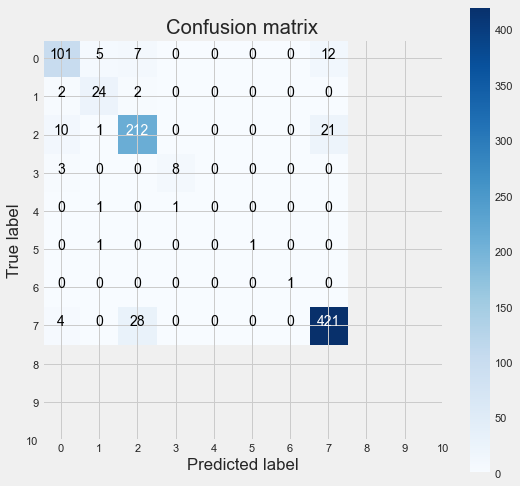

In [193]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision = 2)
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Confusion matrix')

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



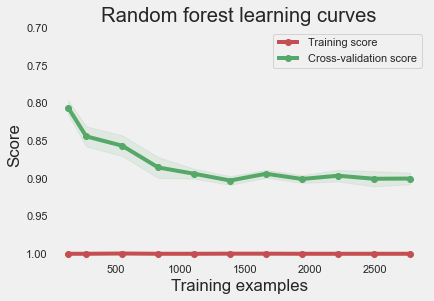

In [194]:
g = plot_learning_curve(random_forest_cv.best_estimator_, 'Random forest learning curves', X_train, y_train, ylim = [1.01, 0.7],
                        cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

##### 5.6 AdaBoost classifier

In [195]:
ada = AdaBoostClassifier()
ada_cv = GridSearchCV(estimator = ada, param_grid = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], cv = 5)

In [196]:
ada_cv = ada_cv.fit(X_train, y_train)

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [197]:
score = ada_cv.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 73.56%


In [198]:
preds = ada_cv.predict(X_test)

Confusion matrix, without normaliztion


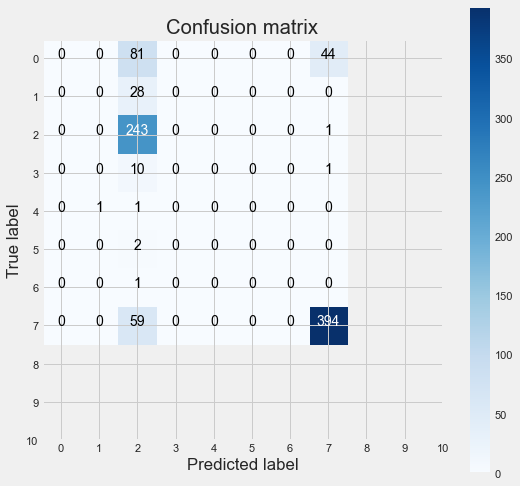

In [199]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision = 2)
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Confusion matrix')

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



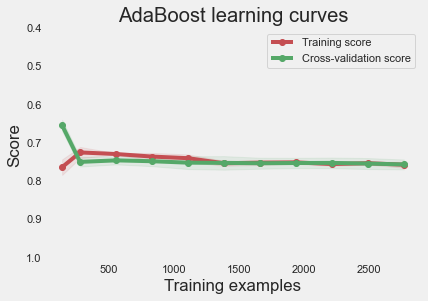

In [200]:
g = plot_learning_curve(ada_cv.best_estimator_, 'AdaBoost learning curves', X_train, y_train, ylim = [1.01, 0.4],
                        cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

##### 5.7 Gradient boosting classifier

In [201]:
gb = ensemble.GradientBoostingClassifier()
gb_cv = GridSearchCV(estimator = gb, param_grid = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], cv = 5)

In [202]:
gb_cv = gb_cv.fit(X_train, y_train)

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [203]:
score = gb_cv.score(X_test, y_test)
print('Accuracy: {:.2%}'.format(score))

Accuracy: 88.11%


In [204]:
preds = gb_cv.predict(X_test)

Confusion matrix, without normaliztion


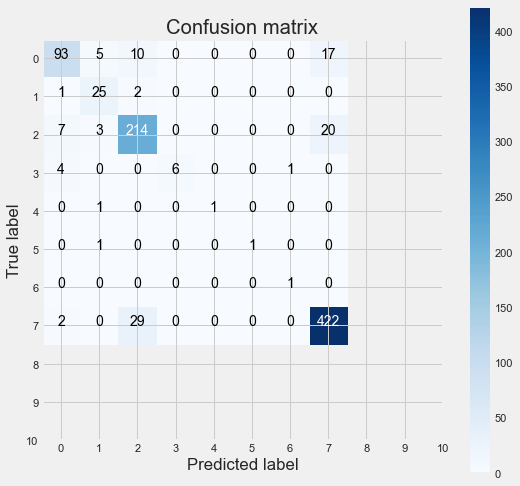

In [205]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(y_test, preds)
np.set_printoptions(precision = 2)
plt.figure(figsize = (8, 8))
plot_confusion_matrix(cnf_matrix, classes = class_names, normalize = False, title = 'Confusion matrix')

C:\Users\User\anaconda3\envs\datascience\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



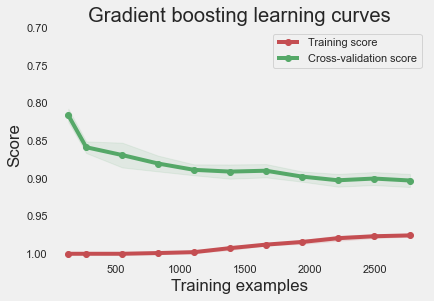

In [206]:
g = plot_learning_curve(gb_cv.best_estimator_, 'Gradient boosting learning curves', X_train, y_train, ylim = [1.01, 0.7],
                        cv = 5, train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

##### 5.8 Let's vote!
Finally, the results of the different classifiers performed in the previous sections can be combined to improve the classification model. This can be achieved be selecting the customer category as the one indicated by the majority of classifiers. To do so, I use the VotingClassifier method from scikit-learn library. As a first step, I adjust the parameters of the various classifiers using the best parameters found prevoiusly:

In [212]:
rf_best = ensemble.RandomForestClassifier(**random_forest_cv.best_params_)
gb_best = ensemble.GradientBoostingClassifier(**gb_cv.best_params_)
svc_best = svm.LinearSVC(**clf.best_params_)
tr_best  = DecisionTreeClassifier(**decision_tree_cv.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn_cv.best_params_)
lr_best  = linear_model.LogisticRegression(**log_regression_cv.best_params_)

Subsequently, I define a classifier that merges the results of the various classifiers:

In [214]:
votingC = ensemble.VotingClassifier(estimators = [('rf', rf_best), ('gb', gb_best), ('knn', knn_best)], voting = 'soft')

... and train it:

In [215]:
votingC = votingC.fit(X_train, y_train)

Finally, we can create a prediction:

In [216]:
predictions = votingC.predict(X_test)
score = votingC.score(X_test, y_test)
print('Precision: {:.2f}%'.format(100 * metrics.accuracy_score(y_test, predictions)))
print('Test set accuracy: {:.2%}'.format(score))

Precision: 89.15%
Test set accuracy: 89.15%


#### 6. Testing predictions

In [221]:
classifiers = [(clf, 'Support Vector Machine'), (log_regression_cv, 'Logistic Regression'), (knn_cv, 'k-Nearest Neighbors'),
               (decision_tree_cv, 'Decision Tree'), (random_forest_cv, 'Random Forest'), (gb_cv, 'Gradient Boosting')]

for clf, label in classifiers:
    print(30 * '_', '\n{}'.format(label))
    score = clf.score(X_test, y_test)
    print('Accuracy: {:.2%}'.format(score))

______________________________ 
Support Vector Machine
Accuracy: 88.11%
______________________________ 
Logistic Regression
Accuracy: 87.99%
______________________________ 
k-Nearest Neighbors
Accuracy: 89.38%
______________________________ 
Decision Tree
Accuracy: 83.37%
______________________________ 
Random Forest
Accuracy: 88.68%
______________________________ 
Gradient Boosting
Accuracy: 88.11%


Ultimately, as anticipated in section 5.8, it is possible to improve the quality of the classifier by combining their respective predictions. At this stage, I chose to combine Random Forest, Gradient Boosting and k-Nearest Neighbors predictions because of slight improvement in ultimate predictions:

In [222]:
predictions = votingC.predict(X_test)
print('Precision: {:.2f}%'.format(100 * metrics.accuracy_score(y_test, predictions)))

Precision: 89.15%


#### 7. Conclusion
JUPYTER NOTEBOOK OF LAST RESORT!!!